# Train without normalize

This notebook will use the KuHar view (balanced_motionsense_equivalent_view) and will:

1. Apply DFT over dataset windows
2. Train three times with RF, SVM and KNN, and take the average accuracy and f1-score
3. Plot UMAP and T-SNE

In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from librep.datasets.har.loaders import KuHar_BalancedView20HzMotionSenseEquivalent
from librep.datasets.multimodal import TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-10-31 15:21:37.863368: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-31 15:21:37.863388: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Load KuHar, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = KuHar_BalancedView20HzMotionSenseEquivalent("../../data/views/KuHar/balanced_20Hz_motionsense_equivalent-v1", 
                              download=False)
train_val, test = loader.load(concat_train_validation=True, label="standard activity code")
train_val

PandasMultiModalDataset: samples=3114, features=360, no. window=6, label_columns='standard activity code'

In [4]:
train_val.window_names, train_val.window_slices

(['accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z'],
 [(0, 60), (60, 120), (120, 180), (180, 240), (240, 300), (300, 360)])

In [5]:
# Checking the whole data...
train_val[:][0]

array([[ -1.04282825,   7.06961015,   3.45567162, ...,   0.50890319,
         -0.11305444,  -0.38018973],
       [ -2.43790048,  -2.62844861,  -2.16686063, ...,  -0.09413675,
         -0.23829967,   0.3772596 ],
       [ -0.66433712,   0.48346468,   3.09023849, ...,   0.28845053,
          0.11892508,   0.28859494],
       ...,
       [  3.92724394,  19.31137994,   0.4036726 , ...,   0.92610044,
          1.03635366,  -0.09064377],
       [ -7.20889409, -11.73424672,  13.67743163, ...,  -0.13913523,
          0.74242743,   0.76542017],
       [ -1.30519969,   0.77625489,  -2.01040912, ...,   0.53948006,
          1.16119165,  -0.4627136 ]])

In [6]:
train_val[0][0].shape

(360,)

In [7]:
# Create the objects

fft_transform = FFT(centered=True)

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[fft_transform], new_window_name_prefix="fft."
)

In [8]:
# Transform it and generate a new dataset!
train_val_fft = transformer(train_val)
test_fft = transformer(test)

In [9]:
# Checking the whole data...
train_val_fft[:][0]

array([[ 5.02447148,  1.61251322,  6.76232259, ...,  0.61856338,
         1.44669533,  0.76661466],
       [ 3.57299732, 10.83009996, 11.81552738, ...,  0.33707892,
         0.57328104,  1.73237447],
       [18.92428589, 22.85409918, 26.51434407, ...,  1.28323215,
         0.74769824,  1.31400771],
       ...,
       [37.2112309 , 19.57891073, 22.52651437, ...,  1.15467725,
         1.07398967,  3.41019869],
       [58.00138092, 13.80286188, 11.50619146, ...,  1.93344645,
         6.26234023,  2.55844602],
       [22.52434513, 15.52963032,  4.92321122, ...,  5.31483603,
         3.63845394,  1.15570768]])

## Classification

Let's take the transformed datasets and train using RandomForest, SVM and KNN 3 times each. Then take the average accuracy and f1-score over the runs

In [10]:
# The reporter will be the same

reporter = ClassificationReport(
    use_accuracy=True,
    use_f1_score=True,
    use_classification_report=True,
    use_confusion_matrix=True,
    plot_confusion_matrix=True,
    # normalize='true'
)

### RandomForest

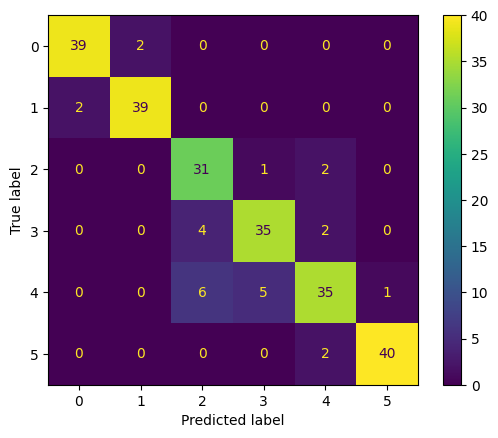

Mean accuracy (3 runs): 0.8902. Mean f1-score: 0.8901


In [11]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
results = multi_run_experiment(train_val_fft, [test_fft])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (3 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")

In [12]:
rf = RandomForestClassifier()
rf.fit(X=train_val_fft[:][0], y=train_val[:][1])
y_pred = rf.predict(test_fft[:][0])

In [13]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

res = f1_score(test[:][1], y_pred, average="weighted")
res

0.8792068073910893

## Plot UMAP and T-SNE

In [14]:
def plot(df, figsize: tuple = (5, 5), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        ax.scatter(group_df.x, group_df.y, label=label)
    ax.legend()
    plt.title(title)
    plt.show()

In [15]:
labels = {
    0: "sit",
    1: "stand",
    2: "walk",
    3: "stair up",
    4: "stair down",
    5: "run"
}
print(labels)

{0: 'sit', 1: 'stand', 2: 'walk', 3: 'stair up', 4: 'stair down', 5: 'run'}


### UMAP

In [16]:
model = UMAP(n_components=2)
model.fit_transform(train_val_fft[:][0])
# result = pd.DataFrame(model.fit_transform(train_val_fft[:][0]), columns=["x", "y"])
# result["label"] = train_val_fft[:][1]
# plot(result, title="UMAP on KuHar FFT data", labels = labels)

array([[-0.94131625, 10.672053  ],
       [-1.066681  , 10.805359  ],
       [-2.0805702 , 10.077073  ],
       ...,
       [ 3.8511686 , 19.15278   ],
       [ 4.43544   , 20.326199  ],
       [ 4.421839  , 19.560732  ]], dtype=float32)

In [17]:
sample = train_val_fft[:1][0][0]
sample

array([  5.02447148,   1.61251322,   6.76232259,  10.26384841,
        29.26908248,  17.54372747, 118.48658158, 138.42720262,
        94.24430978,  49.22627182,  35.45593556,  24.87897343,
        27.02631902, 104.5251306 ,  20.03777732,  79.39405212,
        34.78729105,  34.46044913,  24.55927025,  42.89564689,
        33.20679347,  33.77175868,  24.34724803,  39.41716641,
         4.73864293,  24.00614346,  17.09904876,   7.19171167,
        26.83075435,  27.57197313,   1.78088566,  13.66585042,
        11.22619268,  36.75975242,   3.56771679,   7.48385022,
         4.24605834,  15.72853646,   8.83199145,  16.2599116 ,
        22.10469642,   8.39068229,  17.15094612,  34.36538536,
        18.07976373,   9.68883817,  66.03489565,  19.73558208,
        17.49794533,  18.66662912,  28.29853889,  15.6075191 ,
        11.36365944,  29.49136768,  10.49791718,   6.13987281,
        14.97551951,   1.38848241,   8.48597402,   8.54379177,
        13.40340934,   6.04998625,   1.09898138,   5.58

In [27]:
sample_transform = model.transform([sample])
sample_transform

array([[-0.8625466, 10.677162 ]], dtype=float32)

In [28]:
sample_inverse = model.inverse_transform(sample_transform)[0]
sample_inverse

array([13.9552145 , 13.922041  , 13.450786  , 14.117825  , 19.983341  ,
       33.17117   , 86.76927   , 64.223335  , 33.551353  , 33.08399   ,
       26.901524  , 29.090866  , 31.658474  , 45.212433  , 32.517612  ,
       31.907063  , 25.433872  , 26.24625   , 27.355574  , 36.263577  ,
       24.349684  , 21.659729  , 15.153107  , 13.153488  , 18.016645  ,
       18.394625  , 19.701511  ,  7.9266973 , 10.145273  ,  8.017936  ,
       16.781977  ,  2.338639  ,  3.02369   , 29.867025  , 12.885893  ,
        7.6642804 , 13.600572  ,  7.820836  , 13.387361  , 23.353468  ,
       26.205894  , 13.950124  , 12.208497  , 19.066     , 24.21389   ,
       27.241068  , 33.910038  , 22.970406  , 22.922787  , 14.964573  ,
       16.098137  , 15.260262  , 22.349277  , 14.2631035 , 12.12664   ,
       13.873597  , 13.599333  , 12.177947  , 15.170348  , 12.417809  ,
       19.015316  , 12.526237  , 10.505116  ,  8.867846  ,  6.4441533 ,
       17.685894  , 40.536896  , 29.087263  , 21.654514  , 19.83

In [29]:
diff = sample - sample_inverse
max(np.abs(diff))

74.20386735219685

In [30]:
rf.predict_proba([sample]), rf.predict([sample])

(array([[0.  , 0.  , 0.05, 0.02, 0.91, 0.02]]), array([4]))

In [31]:
rf.predict_proba([sample_inverse]), rf.predict([sample_inverse])

(array([[0.03, 0.03, 0.04, 0.14, 0.3 , 0.46]]), array([5]))

In [32]:
test_fft_umap = model.transform(test_fft[:][0])
test_fft_inverse = model.inverse_transform(test_fft_umap)

In [33]:
y_pred_inverse = rf.predict(test_fft_inverse)

In [34]:
diff_pred = y_pred - y_pred_inverse
diff_pred

array([-1,  0, -1,  0,  2,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  1,  0,
        0,  1,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0, -2, -1, -1, -1,  0,
        0,  0, -1,  0,  0,  1,  0,  1,  0,  0,  1,  0,  0,  1,  1,  1,  0,
        1,  1,  0, -1,  0,  1,  0, -1,  1,  0,  0, -1,  1, -1,  0,  0, -1,
       -1, -1,  0,  0,  1, -1,  0,  0,  0, -1,  0,  0,  1, -1, -1, -3, -1,
        0,  0,  1,  0,  0,  0, -1,  0, -1,  0, -3, -1,  0,  0,  0,  0,  0,
        0, -1, -1, -1,  0,  0,  0,  0, -1, -1, -1, -1, -1, -3, -1, -1, -1,
       -1, -1, -3, -3,  1,  0, -2,  0,  0,  1,  0, -2,  0,  1, -2,  0,  0,
        0, -2,  1,  1,  0,  1,  1,  0,  0,  0,  0,  0,  1,  1,  0,  1,  0,
        1,  0, -2,  0,  1, -2,  0,  1,  0,  0,  1, -2,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -2, -1,  0,  0,  0,  0,  0,  0,  0,  0, -2,  0,  0,
        0,  1,  0, -2,  0,  0,  0,  0,  0,  0,  0, -2,  0,  0, -2,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [35]:
cont = 0
for d in diff_pred:
    if d != 0:
        cont+=1
print(cont, len(diff_pred), cont / len(diff_pred))

90 246 0.36585365853658536
